In [110]:
import sys,os
import numpy as np
import pandas as pd
import pickle

import scipy
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%config InlineBackend.figure_format='retina'

In [111]:
top_viruses = ['u10', 'u102540', 'u11150', 'u202260', 'u39566', 'u134800', 'u102324']

In [112]:
!ls /home/laura/projects/virus-watch-data/logreg_results/1*

/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_donor_time_l2_nocontrol.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_none_l2_nocontrol.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_scramble.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_none_l2_nocontrol.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_none_l2_scramble.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_all_genes_fullM_cov_donor_time_l2_neutrophils.pickle
/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_all_genes_fullM_cov_donor_time_l2_neutrophils_scramble.pickle
/home/laura/project

In [113]:
# first, accuracy of best model vs best model with scramble
models_to_compare = [
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_none_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_donor_time_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_none_l2_nocontrol.pickle',
]

model_names = [
    'HV genes,\nCov',
    'HV genes,\nNo cov',
    'All genes,\nCov',
    'All genes,\nNo cov',
]

accuracy_array = np.ones((len(top_viruses),len(models_to_compare)))

for m, model in enumerate(models_to_compare): 
    
    with open(model, 'rb') as handle:
        results_dict =  pickle.load(handle)
        
    ind = [v in top_viruses for v in results_dict['viruses']]
    
    for v,virus in enumerate(top_viruses):
        ind = [v_ == virus for v_ in results_dict['viruses']]
        accuracy_array[v,m] = results_dict['test_score'][ind]

In [114]:
def heatmap(data, row_labels, col_labels, cmap, ax=None,
            cbar_kw=None, cbarlabel="", fontsize=15,
            aspect = 1.0, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data.T, aspect = aspect, cmap=cmap, vmin=50, vmax=100)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, shrink=0.92, pad=0.01)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize = fontsize+2)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(fontsize)

    # Show all ticks and label them with the respective list entries.
    ax.set_yticks(np.arange(data.shape[1]), labels=col_labels, fontsize = fontsize)
    ax.set_xticks(np.arange(data.shape[0]), labels=row_labels, fontsize = fontsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_yticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize = fontsize,  **kw)
            texts.append(text)

    return texts

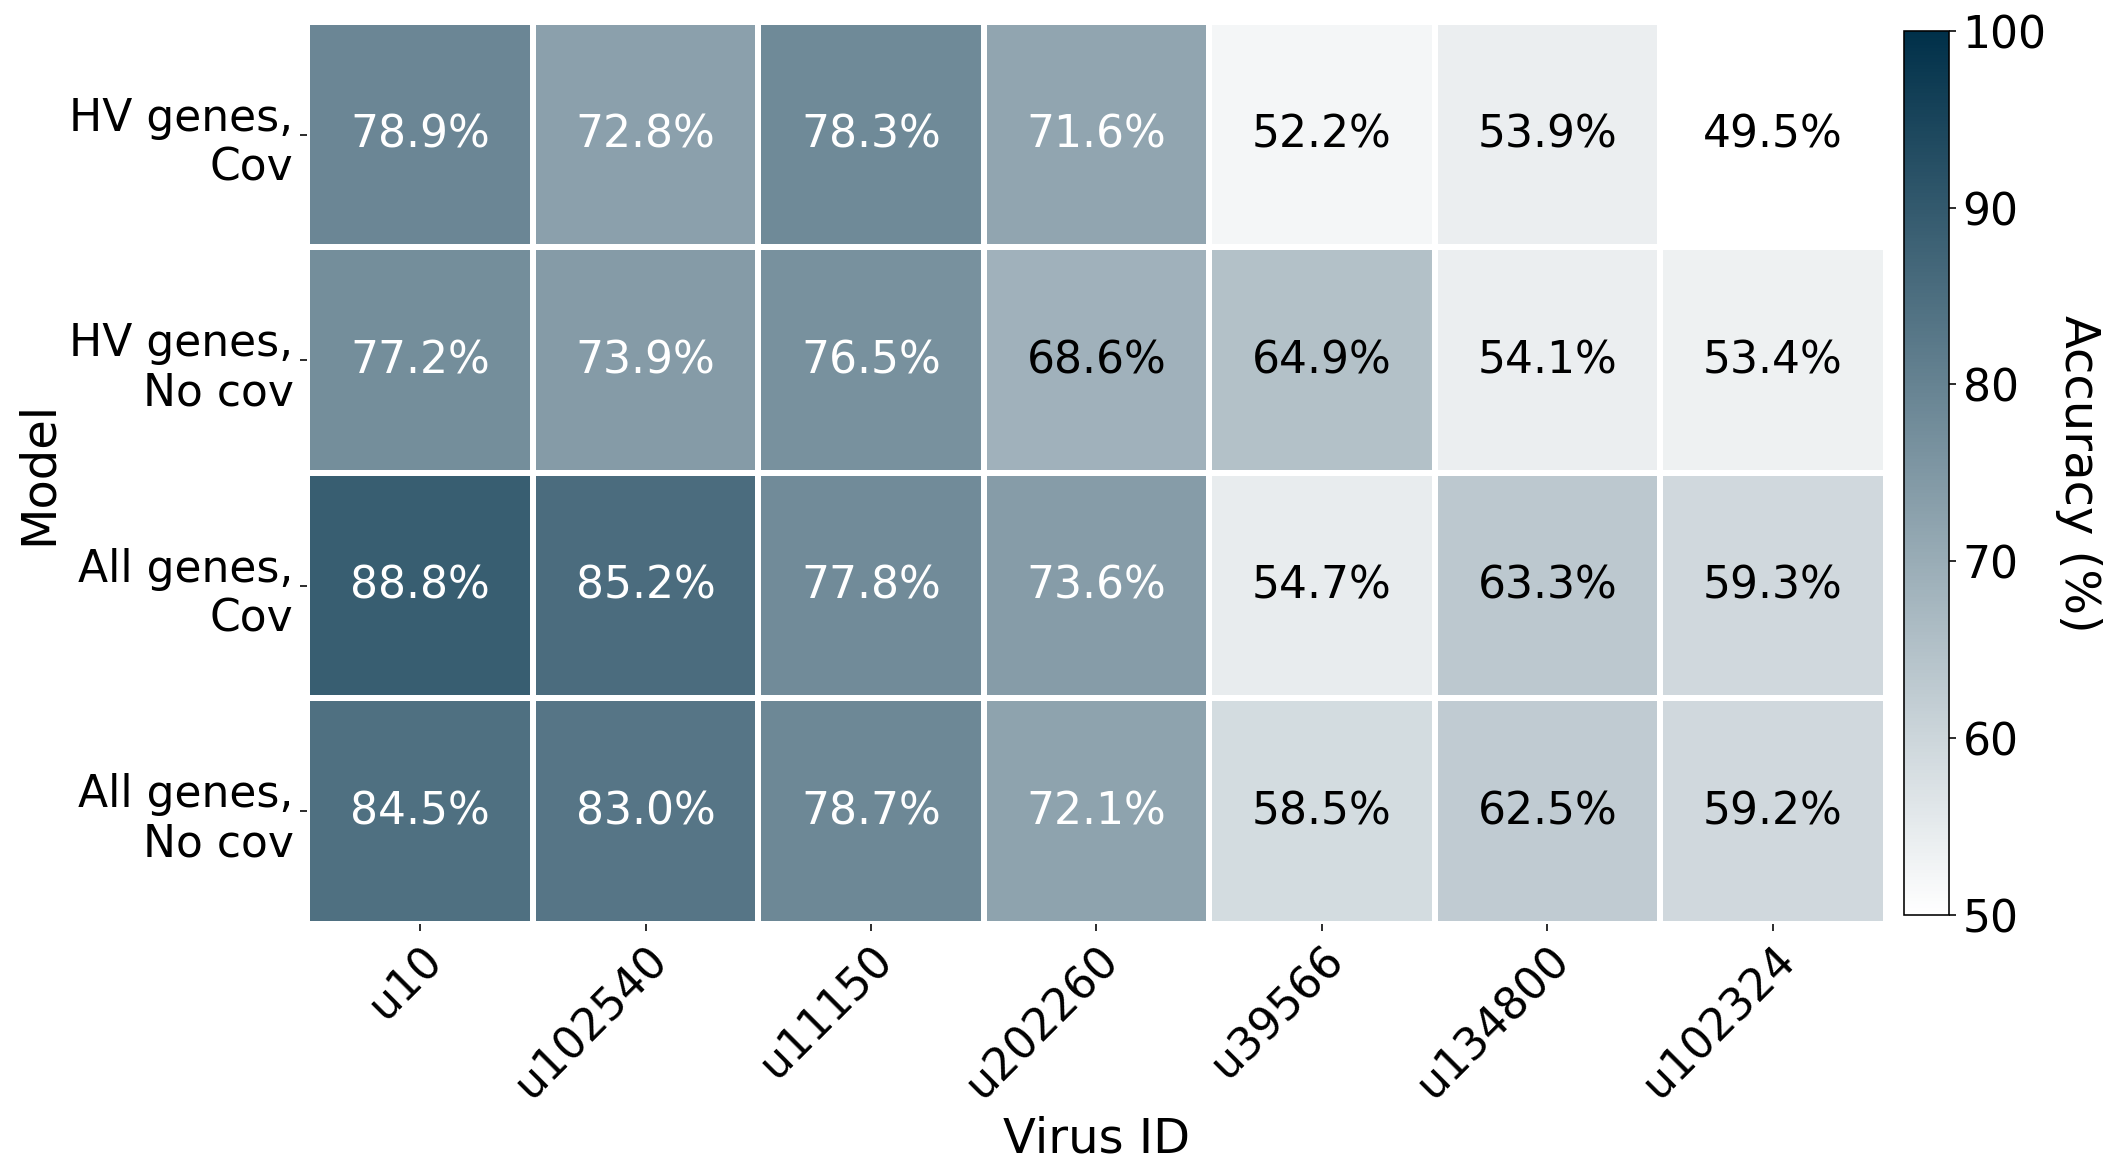

In [115]:
fig, ax = plt.subplots(figsize=(15,8))
fontsize = 22

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','#003049'])

im, cbar = heatmap(accuracy_array*100, top_viruses, model_names, ax=ax,
                   cmap=cmap, cbarlabel="Accuracy (%)",fontsize=fontsize, aspect=1)

texts = annotate_heatmap(im, valfmt="{x:.1f}%")

fig.tight_layout()
plt.xlabel('Virus ID',fontsize=fontsize+2)
plt.ylabel('Model',fontsize=fontsize+2)
plt.savefig('figures/logreg_accuracy_heatmap', dpi=300, bbox_inches= 'tight', transparent=True)
plt.show();

In [116]:
# comparing scramble to no scramble with bar plots
def grouped_barplot(x_labels, data1, data2, bar_width=0.35, 
                    label1='Data 1', label2='Data 2', 
                    x_label='X Axis', y_label='Y Axis',
                    fontsize=15, save_as=None):
    """
    Create a double barplot to compare two sets of data. 
    """
    x = np.arange(len(x_labels))
    
    fig, axs = plt.subplots(figsize=(18, 10), nrows=3, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1], 'hspace': 0.1})
    
    margin = 0.01
    
    ax = axs[0]
    
    rects1 = ax.bar(x - bar_width/2, data1, bar_width, label=label1, color = '#003049')
    rects2 = ax.bar(x + bar_width/2, data2, bar_width, label=label2, color = 'lightgray')
    
    ax.axhline(50, ls="--", color="tab:red", lw=2)
    
    # ax.legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(1, 1), title="Labels", title_fontsize=fontsize)
    ax.legend(fontsize=fontsize, loc='upper right')
    
    ax.tick_params(which='both', labelsize=fontsize)
    ax.set_ylabel(y_label,fontsize=fontsize+2)
    ax.set_xticklabels([])
    
    ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
    ax.set_axisbelow(True)
    ax.xaxis.grid(False)
    
    ax.set_ylim(0,100)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f',color='k',fontsize=fontsize-3)
    ax.margins(x=margin)
    
    ax2 = axs[1]
    
    ax2.bar(top_viruses, num_train,
             bar_width*2, 
             color='grey',label='Virus negative cells')
    
#     ax2.bar(top_viruses, num_pos_train, bar_width*2,  bottom = num_neg_train, 
#              color='#003049', label = 'Virus positive cells')
#     ax2.set_xlabel('Virus ID',fontsize=fontsize)

    ax2.set_xticklabels([])
    
    ax2.set_ylabel('# training\ncells',fontsize=fontsize+2)
    ax2.set_yscale('log')
    
    ax2.tick_params(which='both', labelsize=fontsize)
    
    ax2.grid(True, which="both", color='lightgray', ls="--", lw=1)
    ax2.set_axisbelow(True)
    ax2.xaxis.grid(False)
    
    ax2.set_ylim(1,120000)
    
    for container in ax2.containers:
        ax2.bar_label(container, 
                      labels=[f'{x:,.0f}' for x in container.datavalues],color='k',fontsize=fontsize-3)
        
    ax2.margins(x=margin)  
    
    ax3 = axs[2]
    
    ax3.bar(top_viruses, num_test,
             bar_width*2, 
             color='grey',label='Virus negative cells')
    
#     ax3.bar(top_viruses, num_pos_test, bar_width*2,  bottom = num_neg_test, 
#              color='#003049', label = 'Virus positive cells')

    ax3.set_ylabel('# testing\ncells',fontsize=fontsize+2)
    ax3.set_yscale('log')
    
    ax3.set_xlabel(x_label,fontsize=fontsize+2)
    
    ax3.set_xticks(x, x_labels, fontsize=fontsize)
    # ax3.set_xticklabels(x_labels,rotation=45,fontsize=fontsize, ha = 'right')
    
    ax3.tick_params(which='both', labelsize=fontsize)
    
    ax3.grid(True, which="both", color='lightgray', ls="--", lw=1)
    ax3.set_axisbelow(True)
    ax3.xaxis.grid(False)
    
    ax3.set_ylim(1,1500000) 
    
    for container in ax3.containers:
        ax3.bar_label(container, 
                      labels=[f'{x:,.0f}' for x in container.datavalues],
                      color='k',fontsize=fontsize-3)
    
    ax3.margins(x=margin)
    
    # plt.tight_layout()
    
    if save_as:
        fig.savefig(f'figures/logreg_scrambled_vs_true{save_as}', dpi=300, bbox_inches= 'tight')
    else:
        fig.savefig(f'figures/logreg_scrambled_vs_true', dpi=300, bbox_inches= 'tight')
    fig.show()

In [117]:
with open('/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle', 'rb') as handle:
    results_dict =  pickle.load(handle)
with open('/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_scramble.pickle', 'rb') as handle:
    results_dict_scramble =  pickle.load(handle)
    
unscrambled_accuracy = np.ones(len(top_viruses))
scrambled_accuracy = np.ones(len(top_viruses))
num_training_cells = np.ones(len(top_viruses))
num_train = np.ones(len(top_viruses))
num_neg_train = np.ones(len(top_viruses))
num_test = np.ones(len(top_viruses))
num_neg_test = np.ones(len(top_viruses))

for v,virus in enumerate(top_viruses):
    ind = [v_ == virus for v_ in results_dict['viruses']]
    ind2 = [v_ == virus for v_ in results_dict_scramble['viruses']]
    unscrambled_accuracy[v] = results_dict['test_score'][ind]
    scrambled_accuracy[v] = results_dict_scramble['test_score'][ind2]
    num_train[v] = results_dict['num_training'][ind]
    num_neg_train[v] = results_dict['num_training'][ind]/2
    
    ind_test = np.where(np.array(results_dict['viruses'])==virus)[0][0]
    num_test[v] = len(results_dict['true_all'][ind_test])
    num_neg_test[v] = sum(results_dict['true_all'][ind_test]==0)

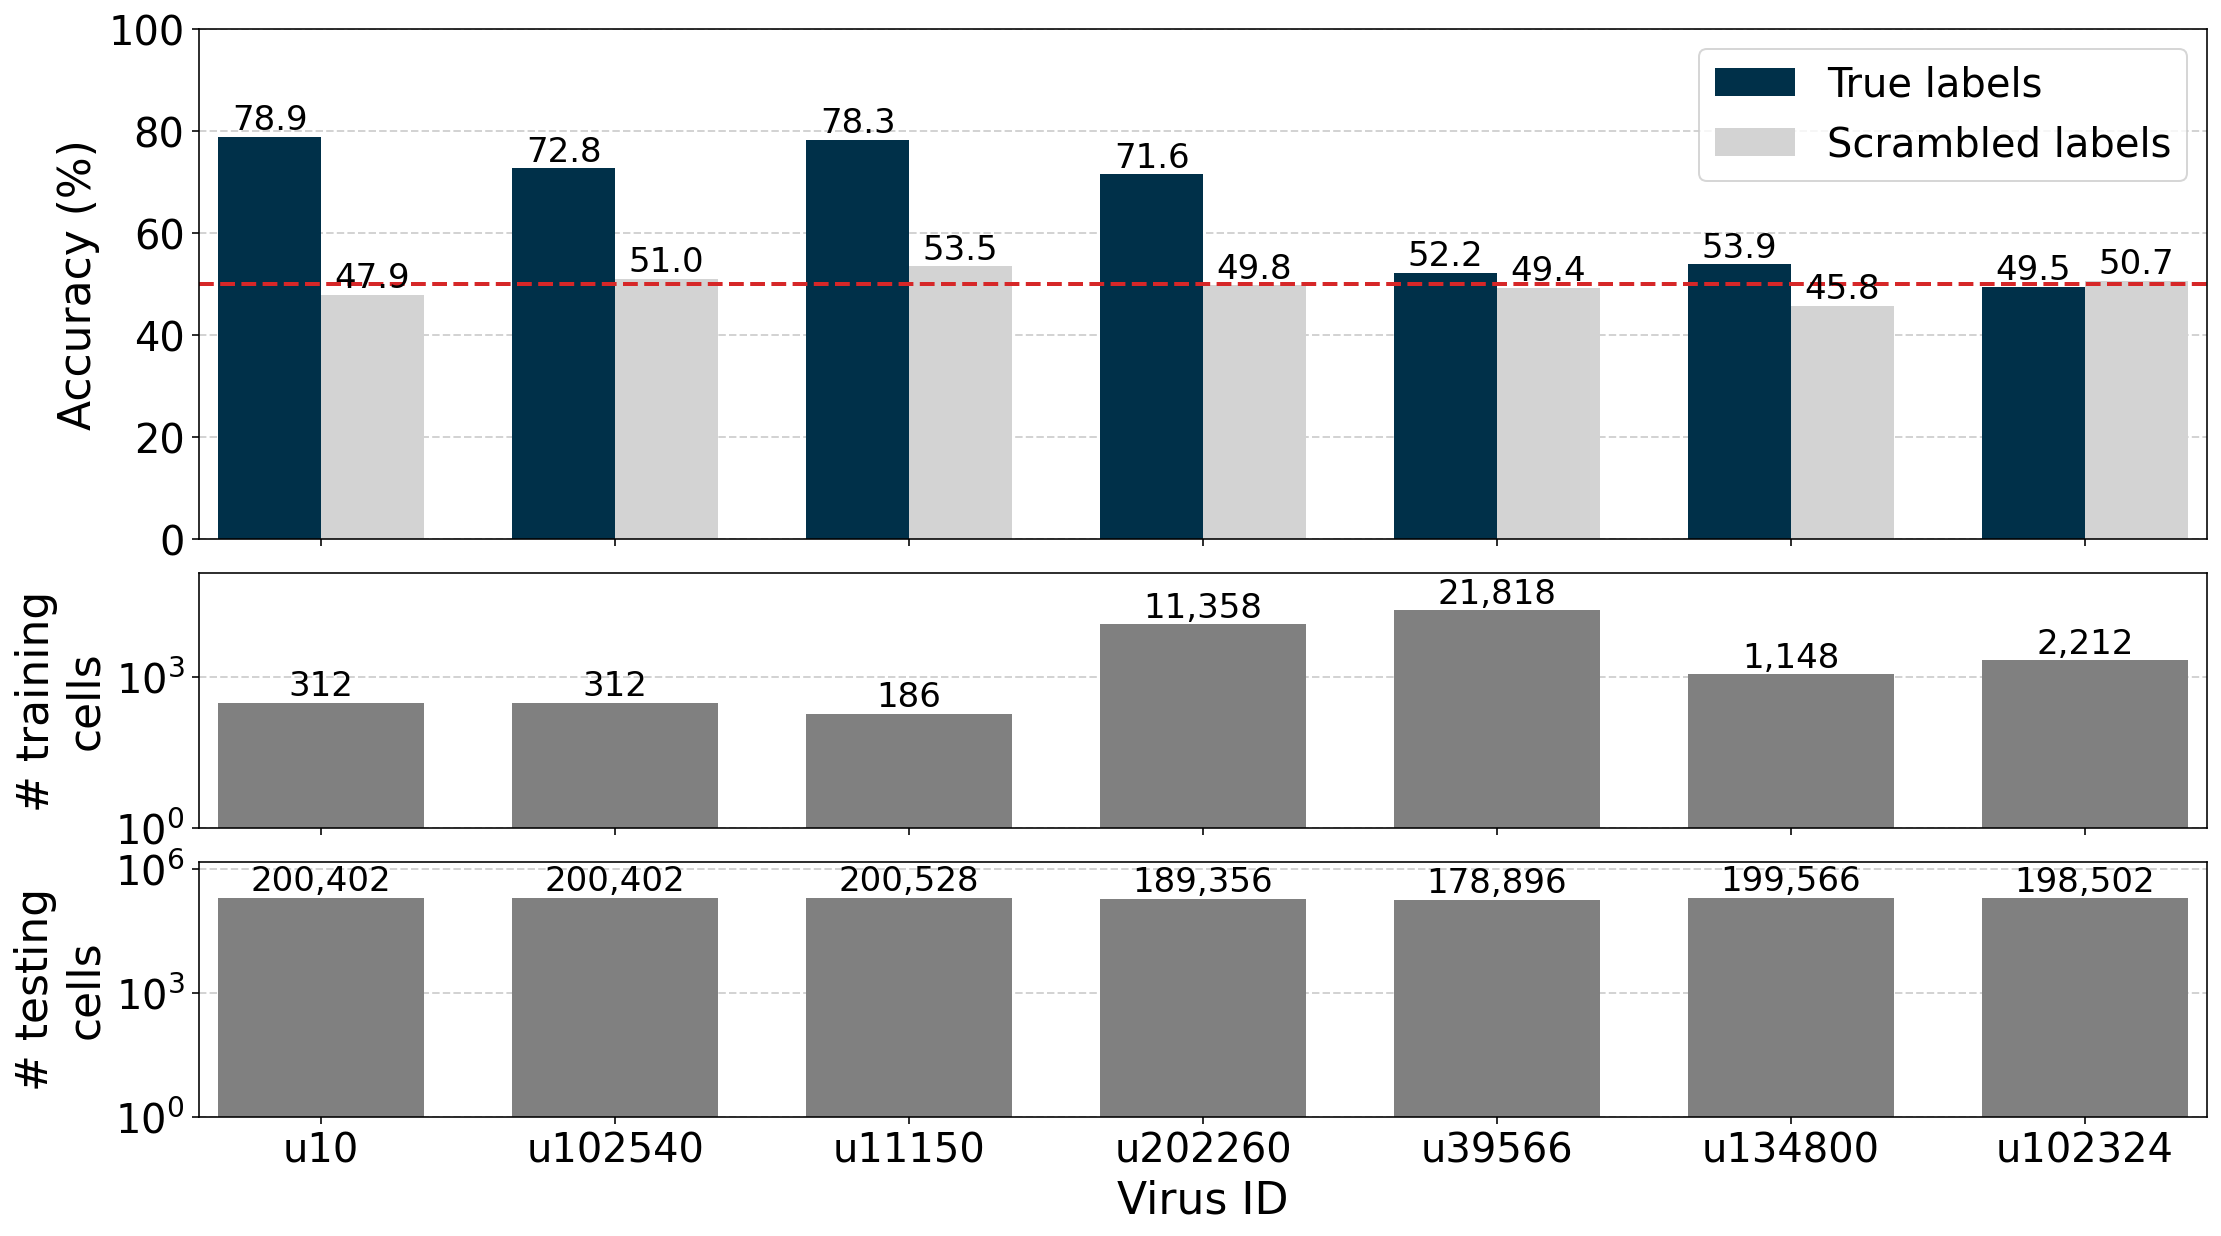

In [118]:
grouped_barplot(top_viruses, 
                unscrambled_accuracy*100, scrambled_accuracy*100,  
                label1='True labels', label2='Scrambled labels', 
                x_label='Virus ID', 
                y_label='Accuracy (%)', fontsize = 20)

### Generate table with numbers of positive/negative cells in training and testing sets

In [119]:
df_num_cells = pd.DataFrame()

df_num_cells["Virus ID"] = top_viruses

df_num_cells["# training cells"] = num_train
df_num_cells["# virus-negative training cells"] = num_neg_train
df_num_cells["# virus-positive training cells"] = num_train - num_neg_train

df_num_cells["# testing cells"] = num_test
df_num_cells["# virus-negative testing cells"] = num_neg_test
df_num_cells["# virus-positive testing cells"] = num_test - num_neg_test

df_num_cells.to_csv("logreg_cell_nums.csv", index=False)

df_num_cells

,Virus ID,# training cells,# virus-negative training cells,# virus-positive training cells,# testing cells,# virus-negative testing cells,# virus-positive testing cells
0,u10,312.0,156.0,156.0,200402.0,200245.0,157.0
1,u102540,312.0,156.0,156.0,200402.0,200245.0,157.0
2,u11150,186.0,93.0,93.0,200528.0,200435.0,93.0
3,u202260,11358.0,5679.0,5679.0,189356.0,5679.0,183677.0
4,u39566,21818.0,10909.0,10909.0,178896.0,167987.0,10909.0
5,u134800,1148.0,574.0,574.0,199566.0,198991.0,575.0
6,u102324,2212.0,1106.0,1106.0,198502.0,197396.0,1106.0


# Supplement

Sensitivity, specificity, and gene correlations.

In [120]:
# first, accuracy of best model vs best model with scramble
models_to_compare = [
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_none_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_donor_time_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_all_genes_fullM_cov_none_l2_nocontrol.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_scramble.pickle'
                    ]

model_names = ['HV genes, Cov',
               'HV genes, No cov',
               'All genes, Cov',
               'All genes, No cov',
               'Scrambled labels'
              ]

model_list = []

sens = [] 
spec = [] 
acc = [] 

for m,model in enumerate(models_to_compare): 

    with open(model, 'rb') as handle:
        results_dict =  pickle.load(handle)
        

    for v,virus in enumerate(top_viruses):
        ind = [v_ == virus for v_ in results_dict['viruses']]

        sens.append(results_dict['test_sensitivity'][ind])
        spec.append(results_dict['test_specificity'][ind])
        acc.append(results_dict['test_score'][ind])
        model_list.append(model_names[m])

In [121]:
df_plot = pd.DataFrame(
    {
        'Percent accuracy' : np.array(acc).flatten()*100,
        'Percent sensitivity' : np.array(sens).flatten()*100,
        'Percent specificity' : np.array(spec).flatten()*100,
        'Model' : model_list,
        'Virus ID' : top_viruses*5
    }
)

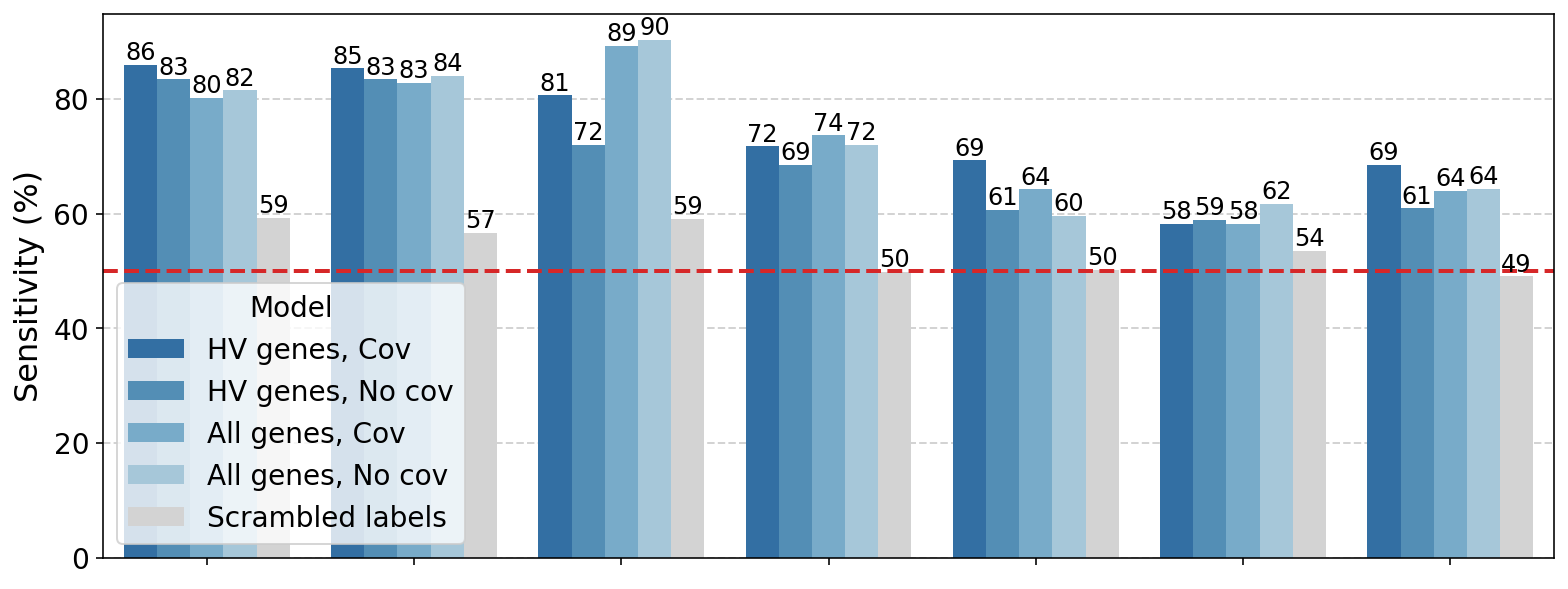

In [122]:
fs = 14
plt.figure(figsize=(13,5))
sens_colors = ['#9ecae1','#6baed6','#4292c6','#2171b5'][::-1]+['lightgrey']
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent sensitivity", hue="Model", palette=sens_colors)
sns.move_legend(ax, "lower left", fontsize=fs)
plt.setp(ax.get_legend().get_title(), fontsize=fs)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
ax.set_axisbelow(True)
ax.axhline(50, ls="--", color="tab:red", lw=2)
ax.xaxis.grid(False)
plt.xlabel('')
ax.set_xticklabels([])
plt.ylabel('Sensitivity (%)',fontsize=fs+2)
plt.xticks(rotation=45,fontsize=fs,ha='right')
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_sens', dpi=300, bbox_inches= 'tight')

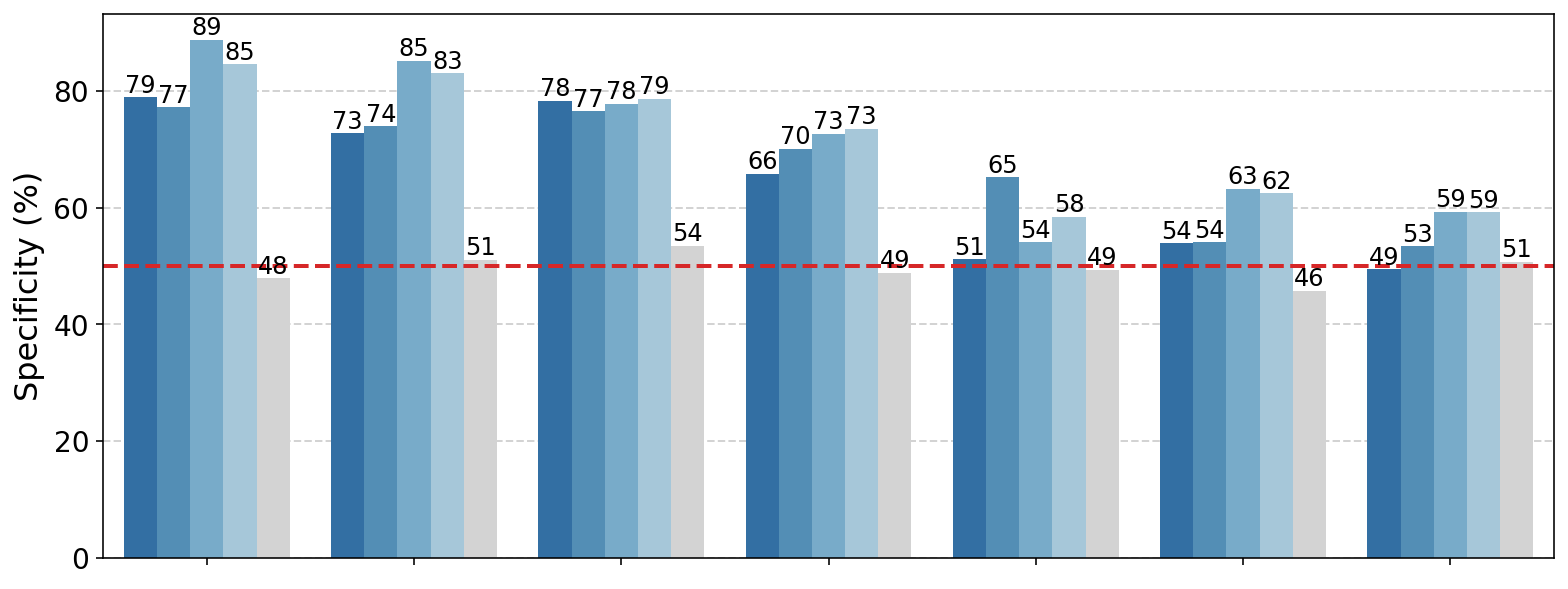

In [123]:
plt.figure(figsize=(13,5))
# spec_colors = ['#bcbddc','#9e9ac8','#807dba','#6a51a3'][::-1]+['#fdae6b']
spec_colors = sens_colors
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent specificity", hue="Model", palette=spec_colors)
# sns.move_legend(ax, "lower left", fontsize=fs)
plt.legend([],[], frameon=False) # remove legend
plt.setp(ax.get_legend().get_title(), fontsize=fs)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.axhline(50, ls="--", color="tab:red", lw=2)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
plt.xlabel('')
ax.set_xticklabels([])
plt.ylabel('Specificity (%)',fontsize=fs+2)
plt.xticks(rotation=45,fontsize=fs,ha='right')
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_spec', dpi=300, bbox_inches= 'tight');

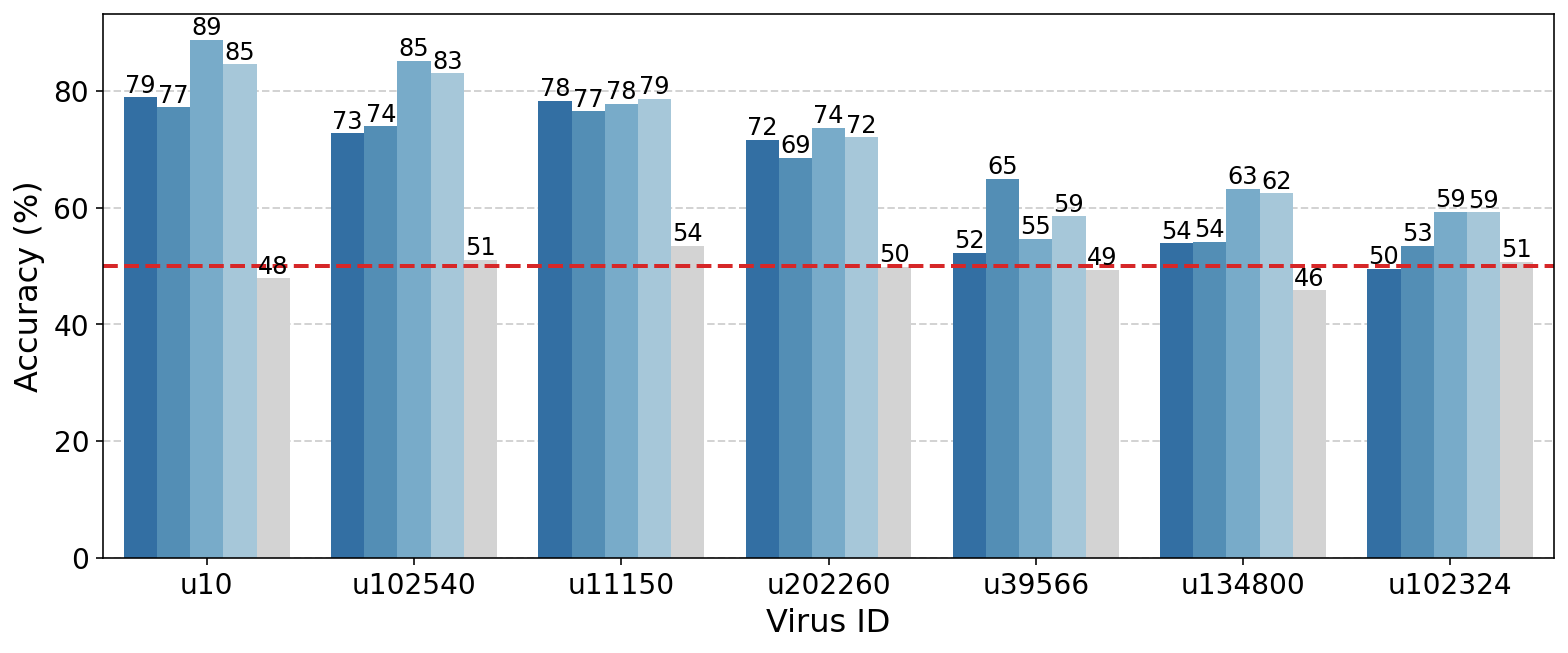

In [124]:
plt.figure(figsize=(13,5))
# acc_colors = ['#a1d99b','#74c476','#41ab5d','#238b45',][::-1]+['#fdae6b']
acc_colors = sens_colors
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent accuracy", hue="Model", palette=acc_colors)
# sns.move_legend(ax, "lower left", fontsize=fs)
plt.legend([],[], frameon=False)
ax.axhline(50, ls="--", color="tab:red", lw=2)
plt.setp(ax.get_legend().get_title(), fontsize=fs)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
plt.xlabel('Virus ID',fontsize=fs+2)
plt.ylabel('Accuracy (%)',fontsize=fs+2)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_acc', dpi=300, bbox_inches= 'tight');

# Accuracy on ALL viruses, 
HV, L2, convariates vs same but scrambled

In [125]:
with open('/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle', 'rb') as handle:
    results_dict_1 =  pickle.load(handle)
with open('/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_scramble.pickle', 'rb') as handle:
    results_dict_2 =  pickle.load(handle)

label_1 = 'True labels'
label_2 = 'Scrambled labels'
metric_varied = 'Model'
viruses = results_dict_1['viruses']

In [126]:
results_df_1 = pd.DataFrame({'virus' : results_dict_1['viruses'],
                           'num_training' : results_dict_1['num_training'],
                           'test_sensitivity' : results_dict_1['test_sensitivity'],
                           'test_specificity' : results_dict_1['test_specificity'],
                           'test_score' : results_dict_1['test_score']*100,
                           metric_varied : [label_1]*len(results_dict_1['viruses'])})


results_df_2 = pd.DataFrame({'virus' : results_dict_2['viruses'],
                           'num_training' : results_dict_2['num_training'],
                           'test_sensitivity' : results_dict_2['test_sensitivity'],
                           'test_specificity' : results_dict_2['test_specificity'],
                           'test_score' : results_dict_2['test_score']*100,
                           metric_varied : [label_2]*len(results_dict_2['viruses'])})


# sort in descending order of viral abudance
custom_order = viruses
# Create a custom order index based on the list
custom_order_index = {value: index for index, value in enumerate(custom_order)}
    # Add a temporary column for sorting
results_df_1['CustomOrderIndex'] = results_df_1['virus'].map(custom_order_index)
# Sort the DataFrame based on the custom order index
results_df_1 = results_df_1.sort_values(by='CustomOrderIndex')
results_df_1.drop('CustomOrderIndex', axis=1, inplace=True)


    # same for df2
results_df_2['CustomOrderIndex'] = results_df_2['virus'].map(custom_order_index)
results_df_2 = results_df_2.sort_values(by='CustomOrderIndex')
results_df_2.drop('CustomOrderIndex', axis=1, inplace=True)


plot_df_1 = results_df_1.melt(id_vars=['virus','num_training',metric_varied],
                          value_vars=['test_specificity','test_sensitivity','test_score'],
                          var_name='metric', value_name='metric_value')
plot_df_2 = results_df_2.melt(id_vars=['virus','num_training',metric_varied],
                          value_vars=['test_specificity','test_sensitivity','test_score'],
                          var_name='metric', value_name='metric_value')

plot_df = pd.concat([results_df_1,results_df_2])

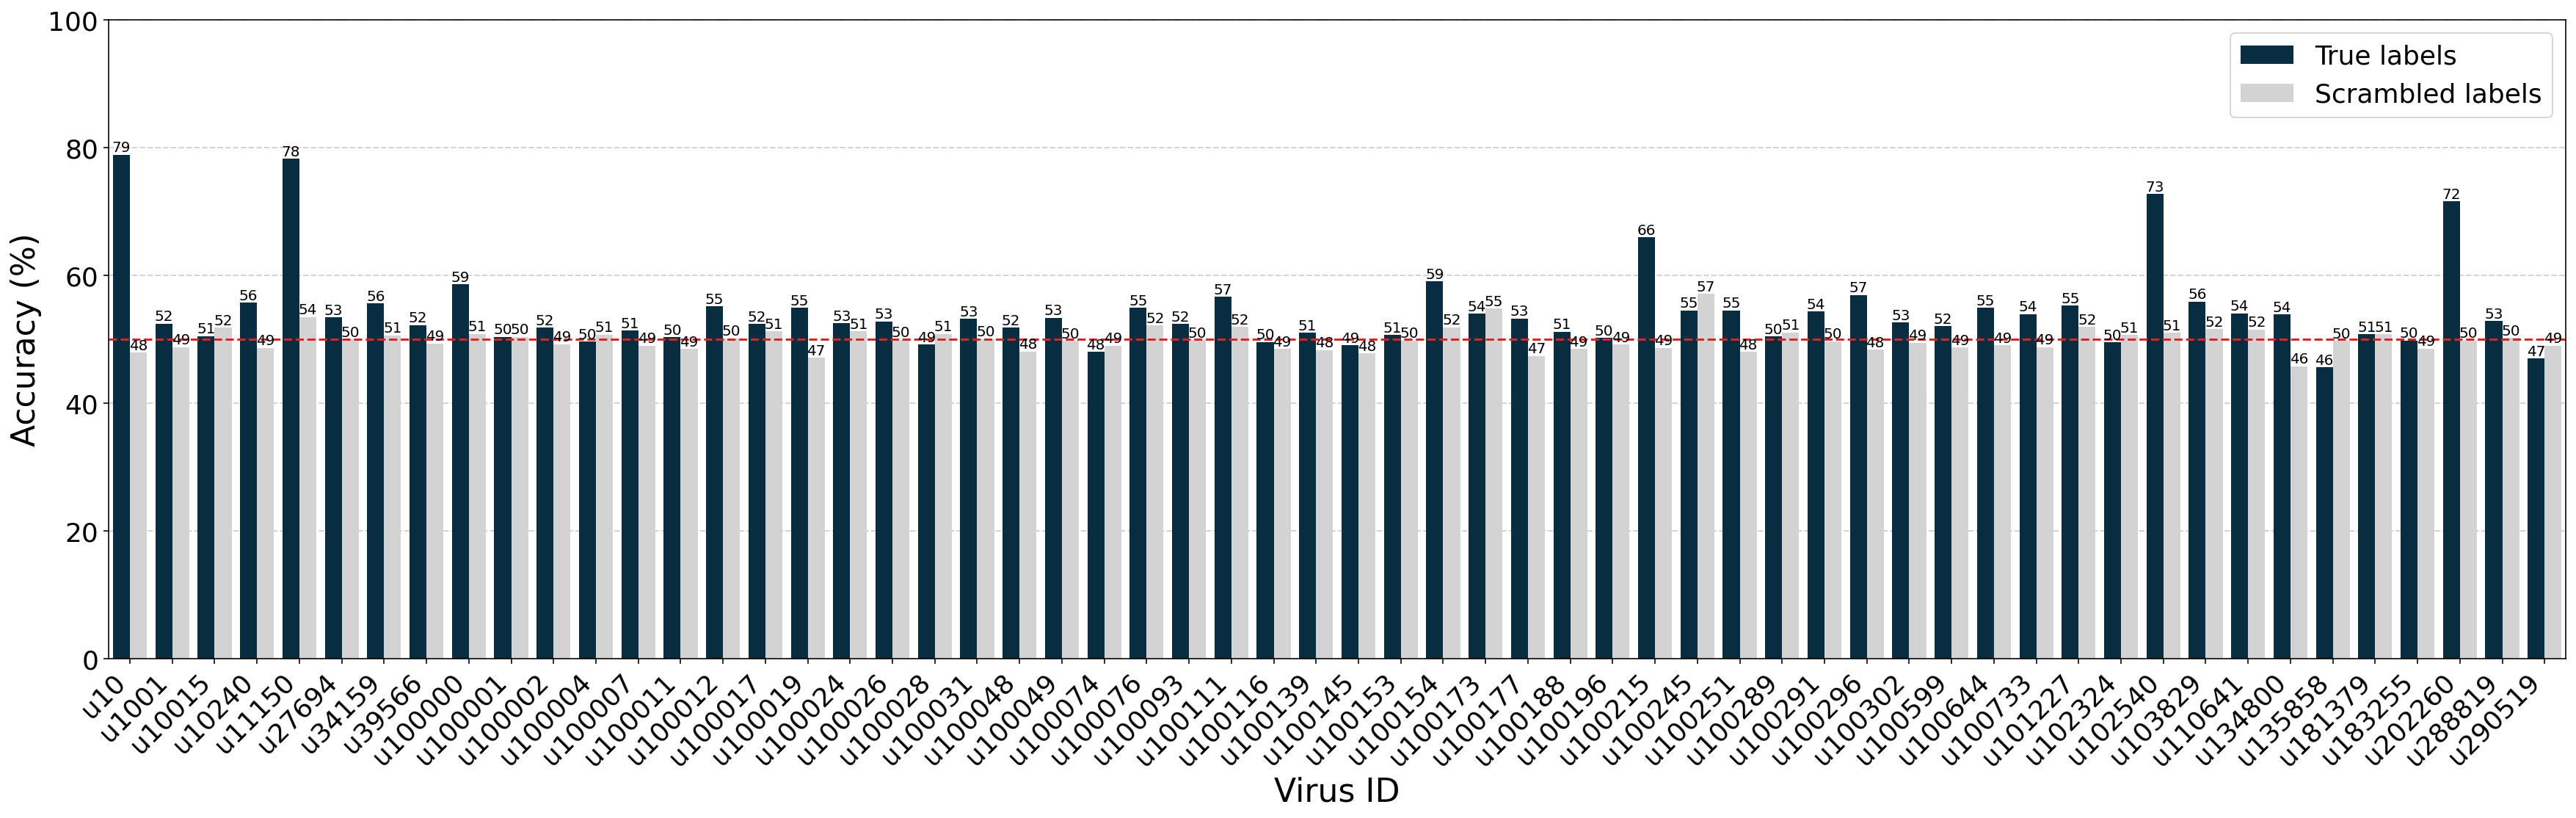

In [127]:
save_path = 'figures/'
fig,ax = plt.subplots(figsize=(30,8))
sns.barplot(data=plot_df,x='virus',y='test_score',hue = metric_varied,
            ax=ax,palette=['#003049','lightgrey'])
ax.tick_params(labelsize=18)
ax.axhline(50, ls="--", color="tab:red", lw=1.5)
plt.legend(fontsize=18)
plt.setp(ax.get_legend().get_title(), fontsize='20')
plt.xlabel('Virus ID',fontsize=22)
plt.ylabel('Accuracy (%)',fontsize=22)
for container in ax.containers:
        ax.bar_label(container, fmt='%.0f',color='k',fontsize=10)
#     plt.title('Accuracy (fraction correctly predicted)',fontsize=30)
plt.xticks(rotation=45, ha="right")
plt.ylim(0,100)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
if save_path:
    plt.savefig(os.path.join(save_path,'logreg_test_accuracy_supp_virus.png'),dpi=300,bbox_inches='tight')
plt.show()

## Gene weight correlations

In [128]:
# load in and filter anndata object to obtain info on the gene names and which are highly variable
import anndata
import scanpy as sc

genes_kind = 'hv'
viruses_kind = 'mac'

virus_data_path = '/home/laura/projects/virus-watch-data/PRJNA665227/full_index_no-host-mask/virus_meta_host.h5ad'
host_data_path = '/home/laura/projects/virus-watch-data/PRJNA665227/full_index_stringent_dlist_flank1/macaque_QC_norm_leiden_celltypes.h5ad'

virus_adata = anndata.read_h5ad(virus_data_path)
host_adata = anndata.read_h5ad(host_data_path)

# add unique barcode column
host_adata.obs['unique_bc'] = host_adata.obs['sample_barcode'].astype('str') + host_adata.obs['barcode'].astype('str')

print(host_adata.shape)
virus_adata.obs['unique_bc'] = virus_adata.obs['sample_barcode'].astype('str') + virus_adata.obs.index.astype('str')
host_adata.obs.index = host_adata.obs['unique_bc'] 
virus_adata.obs.index = virus_adata.obs['unique_bc'] 

# remove non macaque genes
host_adata = host_adata[host_adata.obs["species"] == "macaca_mulatta" , host_adata.var["species"] == "macaca_mulatta"]
# remove non macaque viruses and non null cell types
virus_adata = virus_adata[virus_adata.obs["celltype"].notnull(), :]
# remove undefined cell types annd B cells 3 and 7
undefined = ['Undefined 1']
virus_adata = virus_adata[~virus_adata.obs["celltype_clusters"].isin(undefined), :]


all_genes = host_adata.var.index

# filter the host anndata matrix to only contain macaque genes and the viral cells
if genes_kind == 'all': # options: 'all', 'hv', 'threshN' with N being the lowest count sum over all cells to keep a gene
    host_adata = host_adata[host_adata.obs.unique_bc.isin(virus_adata.obs.unique_bc),:]
elif genes_kind == 'hv':
    host_adata = host_adata[host_adata.obs.unique_bc.isin(virus_adata.obs.unique_bc),host_adata.var.highly_variable==True]
elif 'thresh' in genes_kind:
    thresh = int(genes_kind[6:])
    host_adata = host_adata[host_adata.obs.unique_bc.isin(virus_adata.obs.unique_bc),host_adata.X.sum(axis=0)>=thresh]

    
# only take top half expressing cells
summed_raw_counts  = np.array(host_adata.raw.X.sum(axis=1)).flatten()
thresh = np.quantile(summed_raw_counts ,0.5)
host_adata = host_adata[summed_raw_counts>thresh]
virus_adata = virus_adata[summed_raw_counts>thresh]

hv_genes = host_adata.var.index

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(202525, 66553)


In [129]:
gene_weights = {}
num_genes = 2822

models_to_compare = ['/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_nocontrol.pickle',
                     '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_none_l2_nocontrol.pickle',
                     '/home/laura/projects/virus-watch-data/logreg_results/120323_supp_viruses_hv_genes_fullM_cov_donor_time_l2_scramble.pickle',]

for v,virus in enumerate(top_viruses):
    gene_weights[virus] = np.ones((len(models_to_compare), num_genes))
    
    for m,model in enumerate(models_to_compare): 
        
        with open(model, 'rb') as handle:
            results_dict =  pickle.load(handle)
        
        ind = np.where(np.array(results_dict['viruses']) == virus)[0][0]
        
        num_genes = len(hv_genes)
        gene_weights[virus][m,:] = results_dict['weights'][ind,:num_genes]

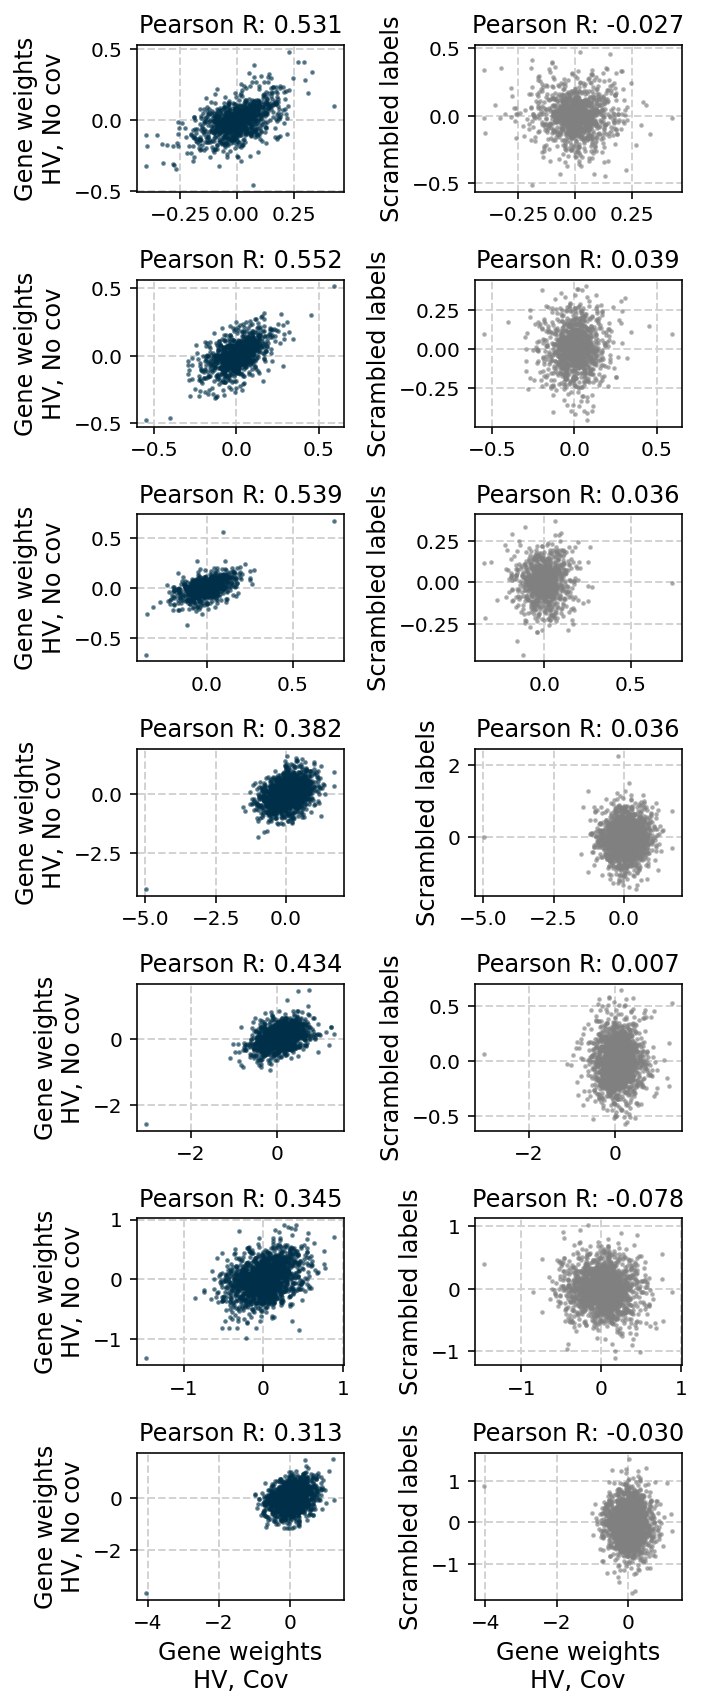

In [130]:
fig, ax = plt.subplots(7,2, figsize = (5, 12))
fs = 12

for v, virus in enumerate(top_viruses):
    
    color = '#003049'
    color2 = 'grey'
    r1,p1 = scipy.stats.pearsonr(gene_weights[virus][0,:],gene_weights[virus][1,:])
    ax[v,0].scatter(gene_weights[virus][0,:],gene_weights[virus][1,:],s=2,color=color,alpha=0.5)

    ax[v,0].grid(True, which="both", color='lightgray', ls="--", lw=1)
    ax[v,0].set_axisbelow(True)
    ax[v,0].set_title(f'Pearson R: {r1:.3f}', fontsize=fs)
    
    ax[v,0].set_ylabel(f'Gene weights\nHV, No cov', fontsize=fs)
    
    if v == len(top_viruses)-1:
        ax[v,0].set_xlabel(f'Gene weights\nHV, Cov', fontsize=fs)
    
    
    r2,p2 = scipy.stats.pearsonr(gene_weights[virus][0,:],gene_weights[virus][-1,:])
    
    ax[v,1].scatter(gene_weights[virus][0,:],gene_weights[virus][-1,:],s=2, color=color2,alpha=0.5)
    ax[v,1].grid(True, which="both", color='lightgray', ls="--", lw=1)
    ax[v,1].set_axisbelow(True)

    ax[v,1].set_title(f'Pearson R: {r2:.3f}', fontsize=fs)
    ax[v,1].set_ylabel(f'Scrambled labels', fontsize=fs)
    if v == len(top_viruses)-1:
        ax[v,1].set_xlabel(f'Gene weights\nHV, Cov', fontsize=fs)
    

plt.tight_layout()
plt.savefig('figures/logreg_gene_weight_scatter', dpi=300, bbox_inches= 'tight')

# Predictions modeled using negative training cells that were the same cell types as positive training cells
Also tried modeling using only neutrophils but that left us with too few cells.

In [197]:
# with open('/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_hv_genes_fullM_cov_donor_time_l2_equalprop.pickle', 'rb') as handle:
#     results_dict =  pickle.load(handle)
# with open('/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_hv_genes_fullM_cov_donor_time_l2_equalprop_scramble.pickle', 'rb') as handle:
#     results_dict_scramble =  pickle.load(handle)
    
# unscrambled_accuracy = np.ones(len(top_viruses))
# scrambled_accuracy = np.ones(len(top_viruses))
# num_training_cells = np.ones(len(top_viruses))
# num_train = np.ones(len(top_viruses))
# num_neg_train = np.ones(len(top_viruses))
# num_test = np.ones(len(top_viruses))
# num_neg_test = np.ones(len(top_viruses))

# for v,virus in enumerate(top_viruses):
#     ind = [v_ == virus for v_ in results_dict['viruses']]
#     ind2 = [v_ == virus for v_ in results_dict_scramble['viruses']]
#     unscrambled_accuracy[v] = results_dict['test_score'][ind]
#     scrambled_accuracy[v] = results_dict_scramble['test_score'][ind2]
#     num_train[v] = results_dict['num_training'][ind]
#     num_neg_train[v] = results_dict['num_training'][ind]/2
    
#     ind_test = np.where(np.array(results_dict['viruses'])==virus)[0][0]
#     num_test[v] = len(results_dict['true_all'][ind_test])
#     num_neg_test[v] = sum(results_dict['true_all'][ind_test]==0)

In [198]:
# grouped_barplot(top_viruses, 
#                 unscrambled_accuracy*100, scrambled_accuracy*100,  
#                 label1='True labels', label2='Scrambled labels',  
#                 x_label='Virus ID', 
#                 y_label='Accuracy (%)', fontsize = 20,
#                save_as = "_equalprop")

### Generate table with numbers of positive/negative cells in training and testing sets
The number of cells should not change here, only which cells were chosen for training changed.

In [199]:
df_num_cells = pd.DataFrame()

df_num_cells["Virus ID"] = top_viruses

df_num_cells["# training cells"] = num_train
df_num_cells["# virus-negative training cells"] = num_neg_train
df_num_cells["# virus-positive training cells"] = num_train - num_neg_train

df_num_cells["# testing cells"] = num_test
df_num_cells["# virus-negative testing cells"] = num_neg_test
df_num_cells["# virus-positive testing cells"] = num_test - num_neg_test

# df_num_cells.to_csv("logreg_cell_nums_equalprop.csv", index=False)

df_num_cells

,Virus ID,# training cells,# virus-negative training cells,# virus-positive training cells,# testing cells,# virus-negative testing cells,# virus-positive testing cells
0,u10,312.0,156.0,156.0,200402.0,200245.0,157.0
1,u102540,312.0,156.0,156.0,200402.0,200245.0,157.0
2,u11150,186.0,93.0,93.0,200528.0,200435.0,93.0
3,u202260,11358.0,5679.0,5679.0,189356.0,5679.0,183677.0
4,u39566,21818.0,10909.0,10909.0,178896.0,167987.0,10909.0
5,u134800,1148.0,574.0,574.0,199566.0,198991.0,575.0
6,u102324,2212.0,1106.0,1106.0,198502.0,197396.0,1106.0


### Sensitivity, specificity, and accuracy

In [221]:
# first, accuracy of best model vs best model with scramble
models_to_compare = [
        '/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_hv_genes_fullM_cov_donor_time_l2_equalprop.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_all_genes_fullM_cov_donor_time_l2_equalprop.pickle',
        '/home/laura/projects/virus-watch-data/logreg_results/120323_top7_viruses_hv_genes_fullM_cov_donor_time_l2_equalprop_scramble.pickle'
                    ]

model_names = ['HV genes, Cov',
               # 'HV genes, No cov',
               'All genes, Cov',
               # 'All genes, No cov',
               'Scrambled labels'
              ]

model_list = []

sens = [] 
spec = [] 
acc = [] 

for m,model in enumerate(models_to_compare): 

    with open(model, 'rb') as handle:
        results_dict =  pickle.load(handle)
        

    for v,virus in enumerate(top_viruses):
        ind = [v_ == virus for v_ in results_dict['viruses']]

        sens.append(results_dict['test_sensitivity'][ind])
        spec.append(results_dict['test_specificity'][ind])
        acc.append(results_dict['test_score'][ind])
        model_list.append(model_names[m])

In [222]:
df_plot = pd.DataFrame(
    {
        'Percent accuracy' : np.array(acc).flatten()*100,
        'Percent sensitivity' : np.array(sens).flatten()*100,
        'Percent specificity' : np.array(spec).flatten()*100,
        'Model' : model_list,
        'Virus ID' : top_viruses*len(models_to_compare)
    }
)

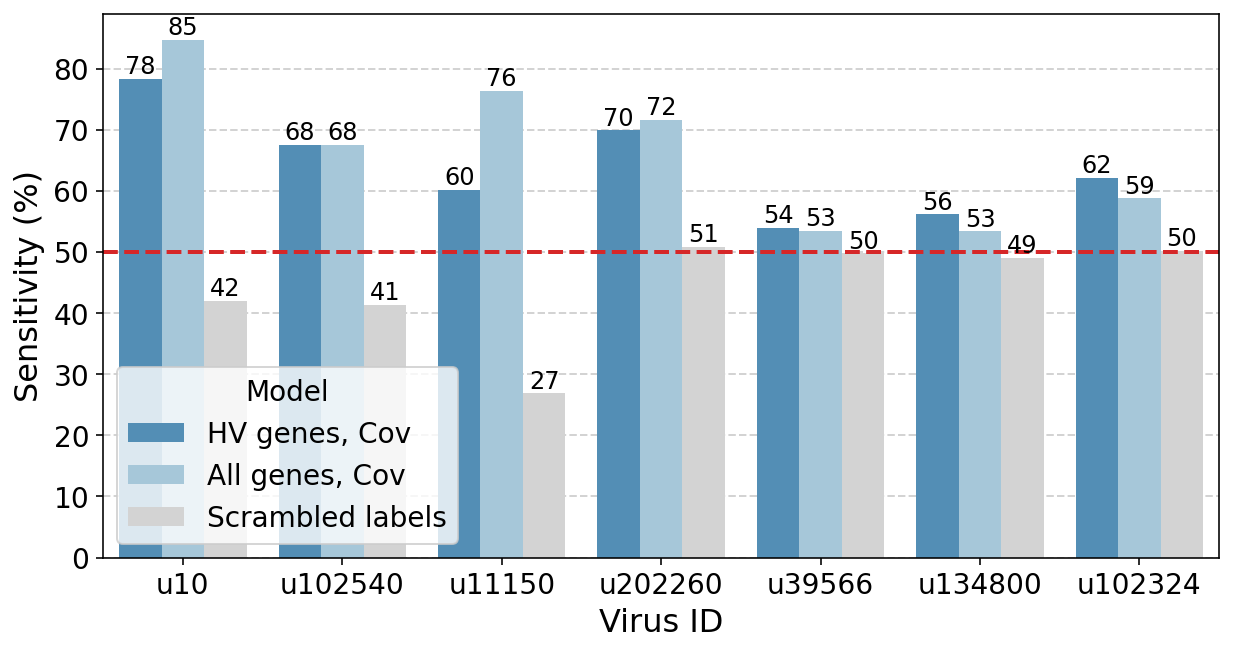

In [223]:
fs = 14
plt.figure(figsize=(10,5))
# sens_colors = ['#9ecae1','#6baed6','#4292c6','#2171b5'][::-1]+['lightgrey']
sens_colors = ['#9ecae1','#4292c6'][::-1]+['lightgrey']
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent sensitivity", hue="Model", palette=sens_colors)
sns.move_legend(ax, "lower left", fontsize=fs)
plt.setp(ax.get_legend().get_title(), fontsize=fs)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
ax.set_axisbelow(True)
ax.axhline(50, ls="--", color="tab:red", lw=2)
ax.xaxis.grid(False)
# plt.xlabel('')
# ax.set_xticklabels([])
plt.xlabel('Virus ID',fontsize=fs+2)
plt.ylabel('Sensitivity (%)',fontsize=fs+2)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_sens_equalprop', dpi=300, bbox_inches= 'tight')

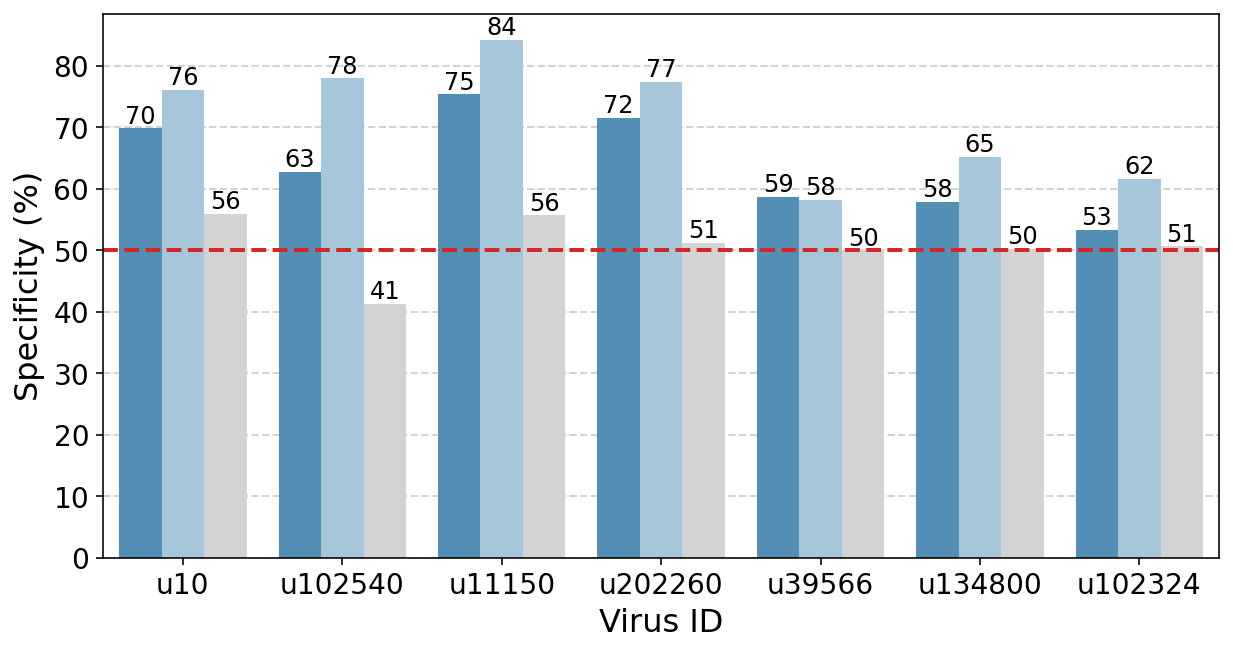

In [224]:
plt.figure(figsize=(10,5))
# spec_colors = ['#bcbddc','#9e9ac8','#807dba','#6a51a3'][::-1]+['#fdae6b']
spec_colors = sens_colors
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent specificity", hue="Model", palette=spec_colors)
# sns.move_legend(ax, "lower left", fontsize=fs)
plt.legend([],[], frameon=False) # remove legend
plt.setp(ax.get_legend().get_title(), fontsize=fs)
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.axhline(50, ls="--", color="tab:red", lw=2)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
# plt.xlabel('')
# ax.set_xticklabels([])
plt.xlabel('Virus ID',fontsize=fs+2)
plt.ylabel('Specificity (%)',fontsize=fs+2)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_spec_equalprop', dpi=300, bbox_inches= 'tight');

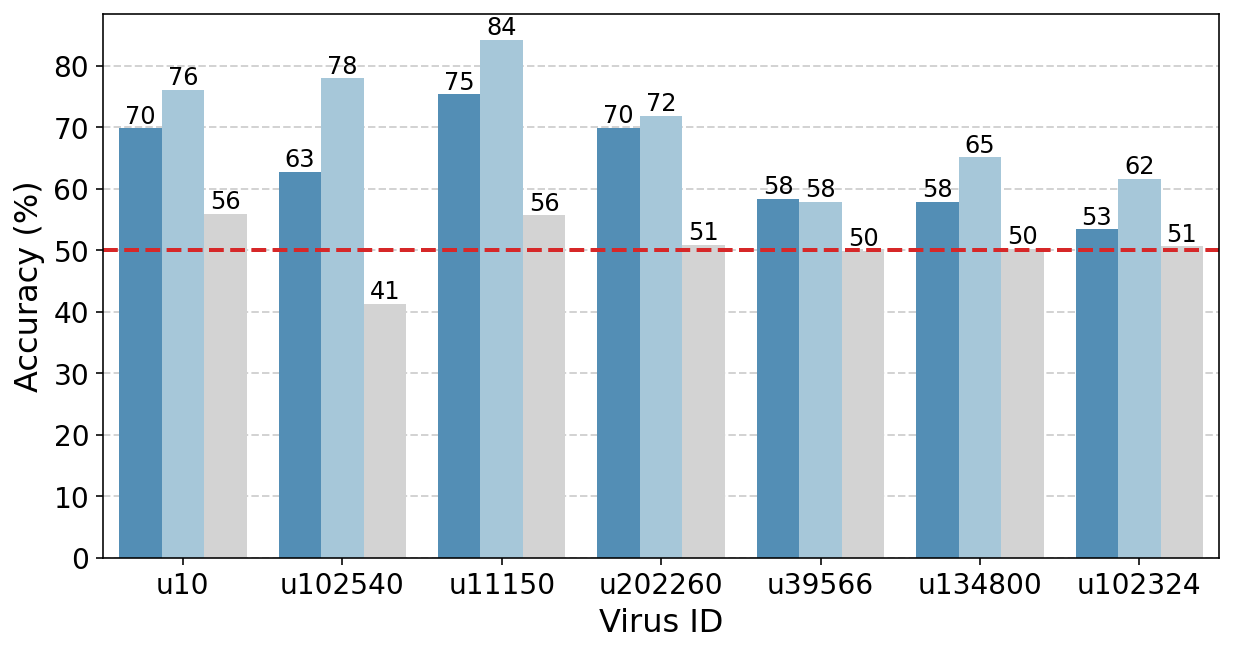

In [225]:
plt.figure(figsize=(10, 5))
# acc_colors = ['#a1d99b','#74c476','#41ab5d','#238b45',][::-1]+['#fdae6b']
acc_colors = sens_colors
ax = sns.barplot(data=df_plot, x="Virus ID", y="Percent accuracy", hue="Model", palette=acc_colors)
# sns.move_legend(ax, "lower left", fontsize=fs)
plt.legend([],[], frameon=False)
ax.axhline(50, ls="--", color="tab:red", lw=2)
plt.setp(ax.get_legend().get_title(), fontsize=fs)

ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f',color='k', fontsize=fs-2)
    
plt.xlabel('Virus ID',fontsize=fs+2)
plt.ylabel('Accuracy (%)',fontsize=fs+2)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('figures/logreg_test_acc_equalprop', dpi=300, bbox_inches= 'tight');

Show cell type breakdown of training cells in this model:

In [302]:
# Number of positive/negative training cells (total # trainig cells = number*2)
ct_nums = {
    "u10":
        {
            "Monocytes": 82*2,
            "T cells": 6*2,
            "B cells": 53*2,
            "Natural killer": 5*2,
            "Immature neutrophils": 5*2,
            "Undefined": 5*2
        },
    
    "u11150":
        {
            "B cells": 18*2,
            "Monocytes": 8*2,
            "T cells": 49*2,
            "Immature neutrophils": 7*2,
            "Undefined": 7*2,
            "Natural killer": 4*2
        },
    
    "u39566":
        {
           "T cells": 3417*2,
           "Monocytes": 1115*2,
           "B cells": 3996*2,
           "Undefined": 1135*2,
           "Natural killer": 889*2,
           "Immature neutrophils": 357*2
        },
    
    "u102324": 
        {
            "Monocytes": 136*2,
            "Immature neutrophils": 89*2,
            "B cells": 416*2,
            "T cells": 314*2,
            "Undefined": 40*2,
            "Natural killer": 111*2
        },

    "u102540":
        {
            "Immature neutrophils": 58*2,
            "B cells": 22*2,
            "T cells": 52*2,
            "Undefined": 20*2,
            "Natural killer": 1*2,
            "Monocytes": 3*2
        },
    
    "u134800":
        {
            "Natural killer": 75*2,
            "T cells": 165*2,
            "B cells": 226*2,
            "Monocytes": 55*2,
            "Undefined": 11*2,
            "Immature neutrophils": 42*2
        },

    "u202260":
        {
            "Natural killer": 566*2,
            "B cells": 2408*2,
            "T cells": 1865*2,
            "Immature neutrophils": 233*2,
            "Monocytes": 464*2,
            "Undefined": 143*2
        }
}

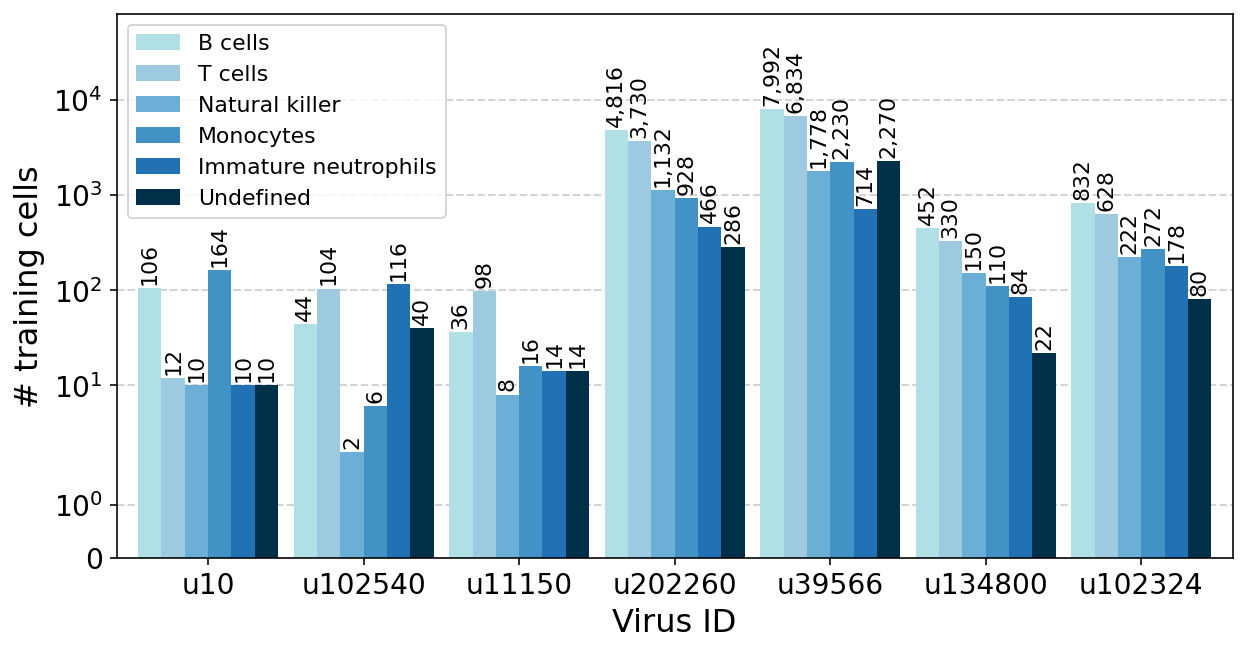

In [306]:
celltypes = ["B cells", "T cells", "Natural killer", "Monocytes", "Immature neutrophils", "Undefined"]
colors = ['powderblue', '#9ecae1','#6baed6','#4292c6','#2171b5', "#003049"]
width = 0.15
positions = [-2.5*width, -1.5*width, -width/2, width/2, 1.5*width, 2.5*width] 

fig, ax = plt.subplots(figsize=(10, 5))
x = 0
fontsize = 14
for vir in top_viruses:
    for i, (pos, ct) in enumerate(zip(positions, celltypes)):
        if vir == top_viruses[0]:
            ax.bar(x+pos, ct_nums[vir][ct], width=width, color=colors[i], label=ct)
        else:
            ax.bar(x+pos, ct_nums[vir][ct], color=colors[i], width=width)
            
        # Add number above bar
        ax.text(x+pos, ct_nums[vir][ct]+0.2*ct_nums[vir][ct], '{:,}'.format(ct_nums[vir][ct]), fontsize=fontsize-3, rotation=90, ha="center")
        
    x += 1

ax.set_xticks(np.arange(len(top_viruses)), top_viruses)
    
ax.grid(True, which="both", color='lightgray', ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

ax.tick_params(axis="both", labelsize=fontsize)

ax.set_ylim(0, 80000)

ax.set_yscale("symlog")
ax.legend(fontsize=fontsize-3, loc="upper left")

ax.margins(x=0.02)

plt.xlabel('Virus ID',fontsize=fontsize+2)
plt.ylabel('# training cells',fontsize=fontsize+2)

plt.savefig('figures/logreg_equalprop_celltypes.png', dpi=300, bbox_inches= 'tight')

fig.show()